In [1]:
import numpy as np 
import os 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
from myheatmap import myheatmap
import matplotlib as mpl
import scipy as sp
import cmasher as cmr # required for choice of cyclic colormaps

############### Mac vs Windows ##############
#folder1 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/2019/2019/08/09/'
#folder2 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/2019/07/30/'
#folder1 = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\2019\2019\08\09'
#folder2 = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\2019\07\30'
folder1 = r'G:\My Drive\Horowitz Research\Oregon\2019-08-09_data_from_Brittany'
folder2 = r'G:\My Drive\Horowitz Research\Oregon\2019-07-30_sample2_data_from_Brittany'

#savefolder = '/Volumes/Aleman-Lab/Group/Papers and Abstracts/Coupled Resonator Spatial Imaging/Figures/python_exports'
savefolder = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Papers and Abstracts\Coupled Resonator Spatial Imaging\Figures\python_exports'
#############################################

ticklength = 2
tickwidth = .5
cbarticklength = 1

print(mpl.__version__) # version 3 required for cmap='twilight_shifted'

sns.set_context('poster') # makes text larger

add_circle = True
plot3d = False
saving = False

## range in which to plot angles
degreerange = (0,360)

## number of bins for histograms
numbins = 65

# colormaps: PiYG, vlag_r, bwr_r, RdBu, Seismic_r, twilight_shifted, cmr.emergency
divergingcmap =  'twilight' # cmr.emergency
cmapforhalf = 'twilight_shifted' # cmr.emergency


# source: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return sp.ma.masked_array(sp.interp(value, x, y))

    
def includeendpoints(alist):
    blist = list([min(degreerange)])
    blist.extend(bin_centers)
    blist.append(max(degreerange))
    return np.array(blist)

def maskplot(df, mk, column, uselog=False, cbarlims = None, **kwargs):
    ### cbarlims is not implemented yet.
#    try:
    rlogmkname = column + 'logmk'
    rmkname = column + 'mk'
    df[rlogmkname] = np.log10((df[column])[mk]) 
    df[rmkname] = (df[column])[mk] # python gives a warning but df.loc[:,(column,mk)] didn't work

    if uselog:
        values = rlogmkname
    else:
        values = rmkname
    dfgrid = df.pivot_table(index = 'Y um', columns = 'X um', values = values).sort_index(axis = 0, ascending = False)
    ax,cbar = myheatmap(dfgrid, values, return_cbar = True, **kwargs)
    plt.xlabel(u'$x$ (μm)')
    plt.ylabel(u'$y$ (μm)')
    plt.gca().axis('equal')
    return ax, cbar

3.3.4


In [2]:
#!pip install hsluv
#!pip install cmasher

<ipython-input-3-410acd67296a>:125: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pmesh = ax.pcolormesh(x, y, z/np.pi,


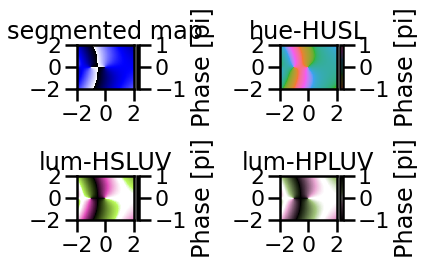

In [3]:
import matplotlib.colors as col
import hsluv # pip install hsluv
import scipy.special # just for the example function

##### generate custom colormaps
def shiftedColorMap(cmap, min_val, max_val, name):
    '''Function to offset the "center" of a colormap. Useful for data with a negative min and positive max and you want the middle of the colormap's dynamic range to be at zero. Adapted from https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib

    Input
    -----
      cmap : The matplotlib colormap to be altered.
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.'''
    epsilon = 0.001
    start, stop = 0.0, 1.0
    min_val, max_val = min(0.0, min_val), max(0.0, max_val) # Edit #2
    midpoint = 1.0 - max_val/(max_val + abs(min_val))
    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)
    # shifted index to match the data
    shift_index = np.hstack([np.linspace(0.0, midpoint, 128, endpoint=False), np.linspace(midpoint, 1.0, 129, endpoint=True)])
    for ri, si in zip(reg_index, shift_index):
        if abs(si - midpoint) < epsilon:
            r, g, b, a = cmap(0.5) # 0.5 = original midpoint.
        else:
            r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)
    return newcmap
def make_segmented_cmap(): 
    white = '#ffffff'
    black = '#000000'
    red = '#ff0000'
    blue = '#0000ff'
    anglemap = col.LinearSegmentedColormap.from_list(
        'anglemap', [black, red, white, blue, black], N=256, gamma=1)
    return anglemap

pink_hue = 326;
green_hue = 109;
pink_sat = 75;
green_sat = 85
maxlum = 105; # white at 100
minlum = 0 # black at zero

def make_anglemap( N = 256, use_hpl = True ):
    h = np.ones(N) # hue
    h[:N//2] = pink_hue 
    h[N//2:] = green_hue
    s = np.ones(N) # saturation
    s[:N//2] = pink_sat 
    s[N//2:] = green_sat
    l = np.linspace(minlum, maxlum, N//2) # luminosity
    l = np.hstack( (l,l[::-1] ) )
    
    colorlist = np.zeros((N,3))
    for ii in range(N):
        if use_hpl:
            colorlist[ii,:] = hsluv.hpluv_to_rgb( (h[ii], s[ii], l[ii]) )
        else:
            colorlist[ii,:] = hsluv.hsluv_to_rgb( (h[ii], s[ii], l[ii]) )
    colorlist[colorlist > 1] = 1 # correct numeric errors
    colorlist[colorlist < 0] = 0 
    return col.ListedColormap( colorlist )

def make_anglemap_r( N = 256, use_hpl = True ):
    h = np.ones(N) # hue
    h[:N//2] = green_hue
    h[N//2:] = pink_hue
    s = np.ones(N) # saturation
    s[:N//2] = green_sat
    s[N//2:] = pink_sat 
    l = np.linspace(minlum, maxlum, N//2) # luminosity
    l = np.hstack( (l,l[::-1] ) )
    
    colorlist = np.zeros((N,3))
    for ii in range(N):
        if use_hpl:
            colorlist[ii,:] = hsluv.hpluv_to_rgb( (h[ii], s[ii], l[ii]) )
        else:
            colorlist[ii,:] = hsluv.hsluv_to_rgb( (h[ii], s[ii], l[ii]) )
    colorlist[colorlist > 1] = 1 # correct numeric errors
    colorlist[colorlist < 0] = 0 
    return col.ListedColormap( colorlist )

N = 256
segmented_cmap = make_segmented_cmap()
flat_huslmap = col.ListedColormap(sns.color_palette('husl',N))
hsluv_anglemap = make_anglemap( use_hpl = False )
hpluv_anglemap = make_anglemap( use_hpl = True )
hsluv_anglemap_r = make_anglemap_r( use_hpl = False )


##### generate data grid
x = np.linspace(-2,2,N)
y = np.linspace(-2,2,N)
z = np.zeros((len(y),len(x))) # make cartesian grid
for ii in range(len(y)): 
    z[ii] = np.arctan2(y[ii],x) # simple angular function
    z[ii] = np.angle(scipy.special.gamma(x+1j*y[ii])) # some complex function

##### plot with different colormaps
fig = plt.figure(1)
fig.clf()
colormapnames = ['segmented map', 'hue-HUSL', 'lum-HSLUV', 'lum-HPLUV']
colormaps = [shiftedColorMap(segmented_cmap,.5,1,'phase'), flat_huslmap, hsluv_anglemap, hpluv_anglemap]
halfangle = shiftedColorMap(hsluv_anglemap,.5,1,'phase')
for ii, cm in enumerate(colormaps):
    ax = fig.add_subplot(2, 2, ii+1)
    pmesh = ax.pcolormesh(x, y, z/np.pi, 
        cmap = cm, vmin=-1, vmax=1)
    plt.axis([x.min(), x.max(), y.min(), y.max()])
    cbar = fig.colorbar(pmesh)
    cbar.ax.set_ylabel('Phase [pi]')
    ax.set_title( colormapnames[ii] )
plt.tight_layout();
plt.show()

#divergingcmap = hsluv_anglemap
##cmapforhalf = hsluv_anglemap_r
#divergingcmap = 'hsv'

In [4]:
### settings for adding grid of circles
pitch = 3.0 # 3 um from one peg to the next
rotationdegrees = -339 # 339 degrees of rotation from straight
radius = .55 # radius of circles to draw in um

xstart = -5.75 
ystart = 10.3

rotation = rotationdegrees * np.pi / (180)
deltax = pitch * np.cos(rotation)
deltay = pitch * np.sin(rotation)

# create grid about origin
xlist = [i*pitch for i in range(-3,6)]
ylist = [i*pitch for i in range(-6,4)]
#display(xlist)

"""    grid = np.meshgrid(xlist,ylist)
print(grid)"""

# rotate grid

# Generate a meshgrid and rotate it by RotRad radians.
# source: https://stackoverflow.com/questions/29708840/rotate-meshgrid-with-numpy
def DoRotation(xspan, yspan, RotRad=0):
    """Generate a meshgrid and rotate it by RotRad radians."""

    # Clockwise, 2D rotation matrix
    RotMatrix = np.array([[np.cos(RotRad),  np.sin(RotRad)],
                          [-np.sin(RotRad), np.cos(RotRad)]])

    x, y = np.meshgrid(xspan, yspan)
    return np.einsum('ji, mni -> jmn', RotMatrix, np.dstack([x, y]))

rotated = DoRotation(xlist,ylist, RotRad=rotation)
#display(rotated)

# translate grid to xstart and ystart
rottrans = rotated.copy()
rottrans[0] = rotated[0]+xstart
rottrans[1] = rotated[1]+ystart

#display(rottrans)

# create tuple list

xs = (rottrans[0]).flatten()
ys = (rottrans[1]).flatten()
coordlist = []
for i in range(len(xs)):
    # only add circle to the coordlist if it's in the mapped region
    if xs[i]>-13.1 and xs[i] < 8.5 and ys[i] > -4 and ys[i] < 17:
        coordlist.append((xs[i], ys[i]))

#display(coordlist)
display(len(coordlist))

# two removed pegs create resonators
coordlist.remove((-4.024362569144298, 6.424154871872494))
coordlist.remove((-0.7990510232365908, 14.826378710347306))


display(len(coordlist))
#display(coordlist)


""" Horrible hack for rotating the image 90 degrees to the right """
def rotatehack(df):
    rotatedf = df.transpose()
    rotatedf.index = -rotatedf.index # I know, it's such a bad hack.
    return rotatedf

# Swap tuple elements in list of tuples 
coordlistrot = [(coord[1], -coord[0]) for coord in coordlist] 

51

49

In [5]:
## slope and offset for correction from Three Mass Model LmFit.ipynb
slope =  -7.51633340320429e-07
offset =  67.96713435722867

def radians_correction(Hz):
    omega = Hz * 2 * np.pi
    return slope * omega + offset

print("Approx correction to radians at 15.16 MHz: add", radians_correction(15.16*1e6)) # radians
print("Approx correction to radians at 15.50 MHz: add", radians_correction(15.5*1e6)) # radians

Approx correction to radians at 15.16 MHz: add -3.628263296731845
Approx correction to radians at 15.50 MHz: add -5.2339648272296415


Correction to radians at low mode, 15.165829099999685 MHz: add -3.6557921049404314


<ipython-input-1-3b29350f94bc>:53: RuntimeWarning: divide by zero encountered in double_scalars
  normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
<ipython-input-1-3b29350f94bc>:57: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  return sp.ma.masked_array(sp.interp(value, x, y))


Correction to radians at high mode, 15.51002004007998 MHz: add -5.281285985147505


<ipython-input-1-3b29350f94bc>:53: RuntimeWarning: divide by zero encountered in double_scalars
  normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
<ipython-input-1-3b29350f94bc>:57: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  return sp.ma.masked_array(sp.interp(value, x, y))
<ipython-input-1-3b29350f94bc>:53: RuntimeWarning: divide by zero encountered in double_scalars
  normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
<ipython-input-1-3b29350f94bc>:57: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  return sp.ma.masked_array(sp.interp(value, x, y))


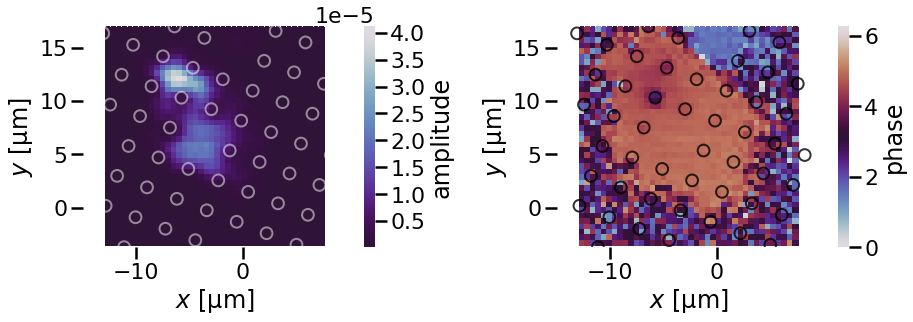

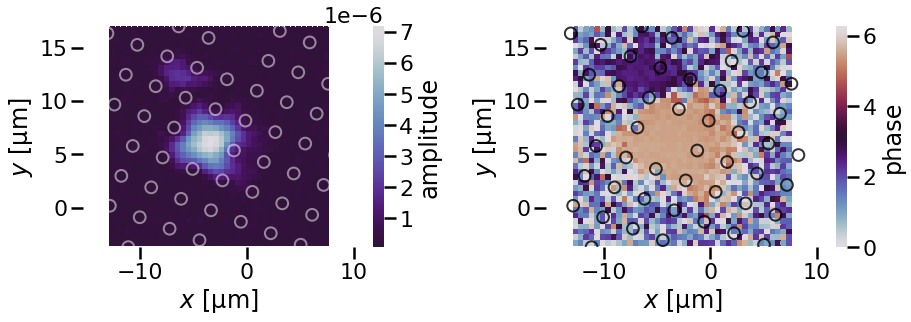

In [6]:
file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum_15.16MHz_1104325' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']
low_mode_Hz = df.frequency[0]
print("Correction to radians at low mode,", low_mode_Hz/1e6 ,"MHz: add", radians_correction(df.frequency[0])) 
# calculate corrected phase
df['phase_cor'] = df.phase + radians_correction(df.frequency[0]) ## correction for radians
df['phase_cor_wrap'] = df.phase_cor % (2 * np.pi)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.23,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1)
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
doubleresonatordata = (amp1)
# set white at max, cut colorbar in half
vmin = np.array(doubleresonatordata).min()
vmax = np.array(doubleresonatordata).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(doubleresonatordata, 'amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='w', fill = None, alpha = .5)
        plt.gca().add_artist(thiscircle)


plt.sca(ax2)
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase_cor_wrap').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase', vmin=0, vmax = 2*np.pi, cmap=divergingcmap);
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)
        
plt.tight_layout();


file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1_15.5MHz105133' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']
high_mode_Hz = df.frequency[0]
print("Correction to radians at high mode,", high_mode_Hz/1e6 ,"MHz: add", radians_correction(df.frequency[0])) 
# calculate corrected phase
df['phase_cor'] = df.phase + radians_correction(df.frequency[0]) ## correction for radians
df['phase_cor_wrap'] = df.phase_cor % (2 * np.pi)

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(13.23,5))

plt.sca(ax3)
amp2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = amp2
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax3.axis('equal');

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='w', fill = None, alpha = .5)
        plt.gca().add_artist(thiscircle)

plt.sca(ax4) 
phase2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase_cor_wrap').sort_index(axis = 0, ascending = False) 
myheatmap(phase2, 'phase', vmin=0, vmax = 2* np.pi, cmap=divergingcmap);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax4.axis('equal');

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
def add_sizebar(ax, size):
    asb = AnchoredSizeBar(ax.transData,
                          size,
                          str(size) + u' μm',
                          loc='lower right',
                          #bbox_to_anchor=(.5,.5),
                          size_vertical=.4,
                          pad=0.1, borderpad=0.5, sep=5,
                          frameon=False)
    ax.add_artist(asb)

    ## uncommenting the following line will create a sizebar a little bit covering the plot
#add_sizebar(ax4, 10)



plt.tight_layout();

<ipython-input-7-0dff8234711a>:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.rnorm = df.r/df.r.max()


Amplitude background threshold is 4e-07 arb. units
Mean background amplitude at 15.16 MHz: 2.2835123523093425e-07
Stdev background amplitude at 15.16 MHz: 7.118495407348469e-08
Max amplitude at 15.16 MHz: 
4.1342e-05


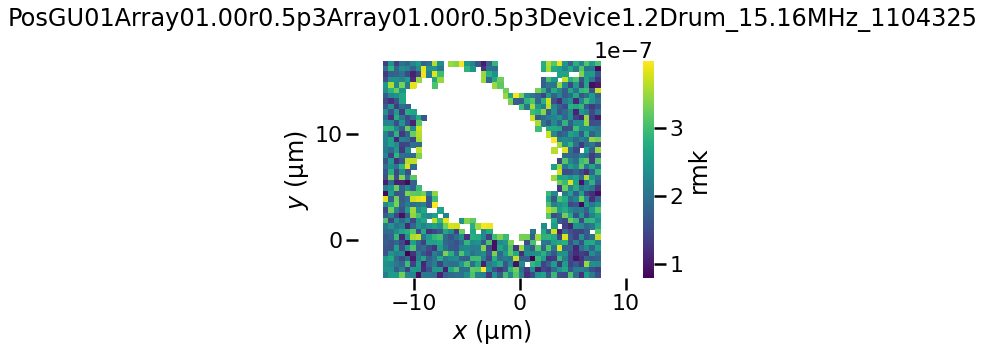

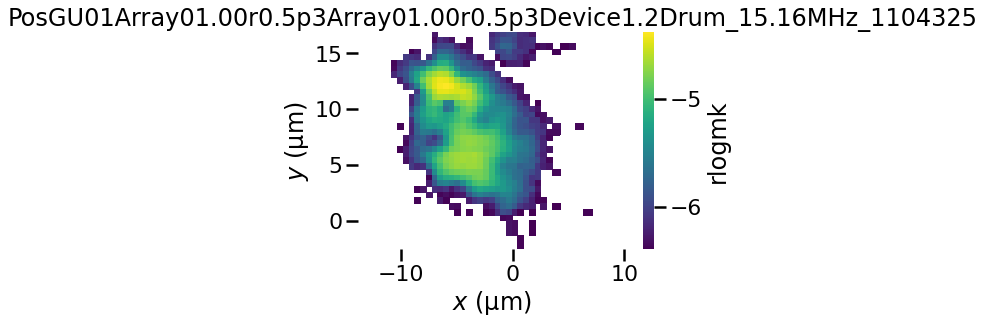

In [7]:

file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum_15.16MHz_1104325' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 

df['X um']=df['Green X']
df['Y um']= df['Green Y']
# calculate corrected phase
df['phase_cor'] = df.phase + radians_correction(df.frequency[0]) ## correction for radians
df['phase_cor_wrap'] = df.phase_cor % (2 * np.pi)

df.rnorm = df.r/df.r.max()

"""## background threshold in rnorm units
backgthresh1516 = 0.0095
print('Amplitude background threshold at 15.16 MHz is currently set to: ' + str(backgthresh1516) + ' of max amplitude = ' 
      + str(backgthresh1516*df.r.max())
      + ' arb. units')"""
## background threshold in r units
backgthresh = 4e-7
print('Amplitude background threshold is ' + str(backgthresh) + ' arb. units')

# Background plot
#mkbackg1516 = df.rnorm < backgthresh1516; # a mask that selects the (low amplitude) background pixels
mkbackg1516 = df.r < backgthresh
plt.figure()
maskplot(df, mkbackg1516, 'r', cmap = 'viridis')
plt.title(file + '\n');
print('Mean background amplitude at 15.16 MHz: '
      + str(np.mean(df[mkbackg1516].r)))
print('Stdev background amplitude at 15.16 MHz: '
     + str(np.std(df[mkbackg1516].r)))
print('Max amplitude at 15.16 MHz: ')
print(df.r.max())

#mk1516 = df.rnorm > backgthresh1516 # a mask that selects the (non-negligible amplitude) foreground pixels
mk1516 = df.r > backgthresh
plt.figure()
maskplot(df, mk1516, 'r', cmap = 'viridis', uselog=True)
plt.title(file);

<ipython-input-8-3591b61bc1e6>:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.rnorm = df.r/df.r.max()


Mean background amplitude at 15.50 MHz: 2.1720738413197153e-07
Stdev background amplitude at 15.50 MHz: 6.438259103781456e-08


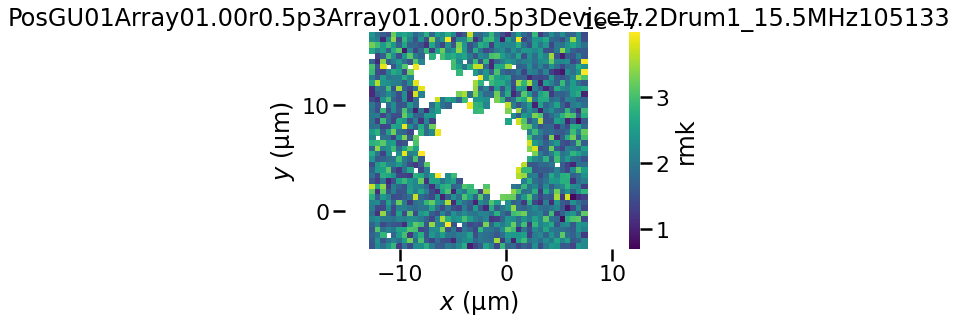

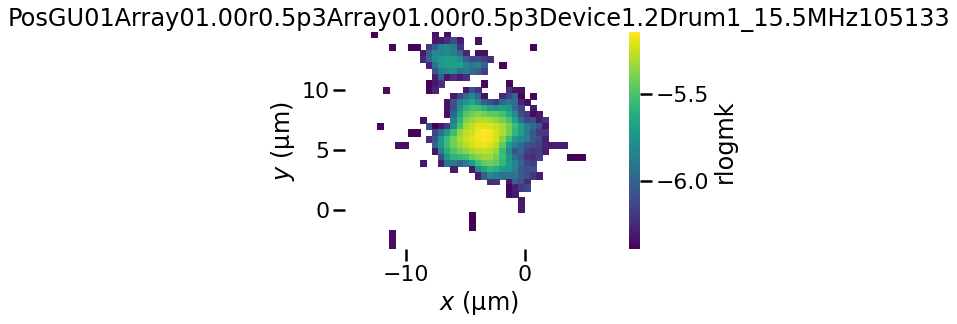

In [8]:
file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1_15.5MHz105133'  
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 

df['X um']=df['Green X']
df['Y um']= df['Green Y']
# calculate corrected phase
df['phase_cor'] = df.phase + radians_correction(df.frequency[0]) ## correction for radians
df['phase_cor_wrap'] = df.phase_cor % (2 * np.pi)

df.rnorm = df.r/df.r.max()

"""## background threshold in rnorm units
backgthresh1550 = 0.06
print('Amplitude background threshold at 15.50 MHz is currently set to: ' + str(backgthresh1550) + ' of max amplitude = ' 
      + str(backgthresh1550*df.r.max())
      + ' arb. units')"""


# Background plot
#mkbackg1550 = df.rnorm < backgthresh1550; # a mask that selects the (low amplitude) background pixels
mkbackg1550 = df.r < backgthresh
plt.figure()
maskplot(df, mkbackg1550, 'r', cmap = 'viridis')
plt.title(file);
print('Mean background amplitude at 15.50 MHz: '
      + str(np.mean(df[mkbackg1550].r)))
print('Stdev background amplitude at 15.50 MHz: '
     + str(np.std(df[mkbackg1550].r)))

#mk1550 = df.rnorm > backgthresh1550 # a mask that selects the (non-negligible amplitude) foreground pixels
mk1550 = df.r > backgthresh
plt.figure()
maskplot(df, mk1550, 'r', cmap = 'viridis', uselog=True)
plt.title(file);

<ipython-input-9-b95c8d0198c7>:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.rnorm = df.r/df.r.max()
<ipython-input-9-b95c8d0198c7>:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.phasedeg_uncor = np.rad2deg(df.phase)
<ipython-input-9-b95c8d0198c7>:15: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.phasedeg = np.rad2deg(df.phase_cor_wrap)
<ipython-input-1-3b29350f94bc>:53: RuntimeWarning: divide by zero encountered in double_scalars
  normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
<ipython-input-1-3b29350f94bc>:57: DeprecationWarning: scipy.interp is deprecated and wi

274.7901482773674
93.99804761333851
Phase difference (deg):
-180.79210066402888


<ipython-input-1-3b29350f94bc>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[rlogmkname] = np.log10((df[column])[mk])
<ipython-input-1-3b29350f94bc>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[rmkname] = (df[column])[mk] # python gives a warning but df.loc[:,(column,mk)] didn't work
<ipython-input-1-3b29350f94bc>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Mean, first peak:
274.7901482773674
Standard dev:
14.896558778847382
Standard error:
0.5992274738826253
Second peak mean:
93.99804761333851
Standard dev:
12.905421336769713
Stderr:
1.8251021882598846
Phase difference (deg): -180.79210066402888 ± 1.920955898256587


<ipython-input-9-b95c8d0198c7>:222: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.phasedeg_uncor = np.rad2deg(df.phase)
<ipython-input-9-b95c8d0198c7>:223: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.phasedeg = np.rad2deg(df.phase_cor_wrap)
<ipython-input-9-b95c8d0198c7>:224: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.rnorm = df.r/df.r.max()
<ipython-input-1-3b29350f94bc>:53: RuntimeWarning: divide by zero encountered in double_scalars
  normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
<ipython-input-1-3b29350f94bc>:57: DeprecationWarning: scipy.interp is deprecated and

rmax = 7.198e-06
149.86683850789393
312.9498215448236
Phase difference (deg):
163.08298303692965


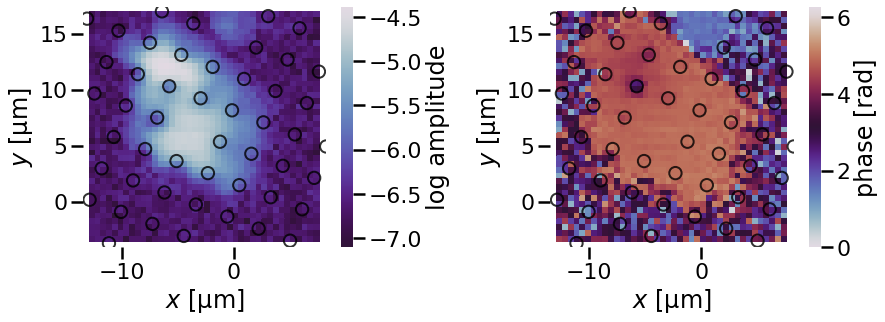

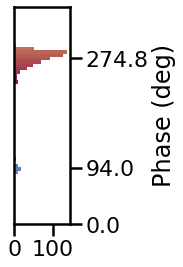

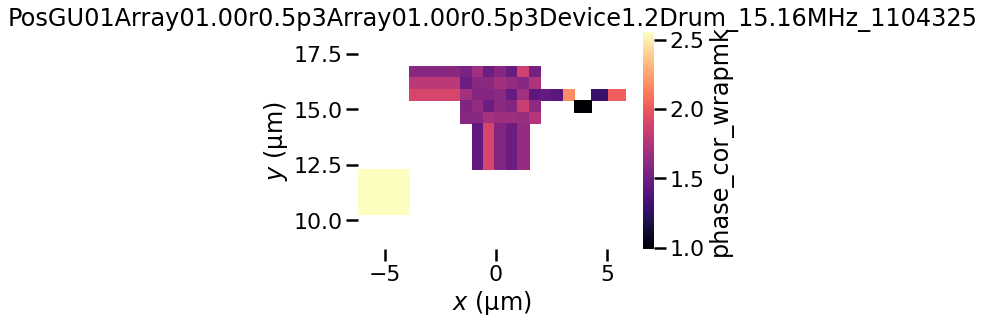

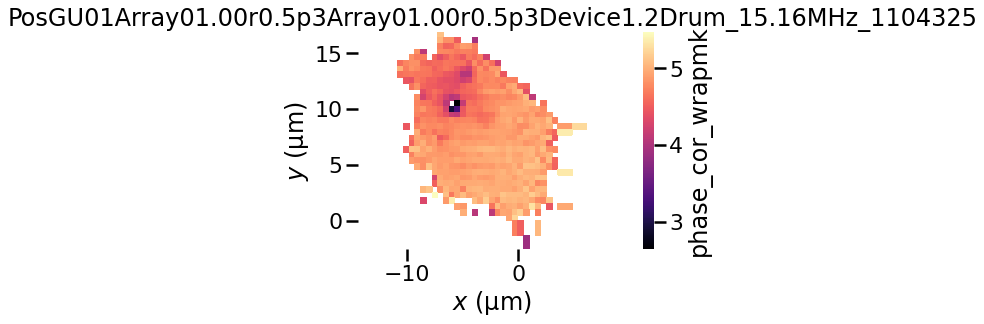

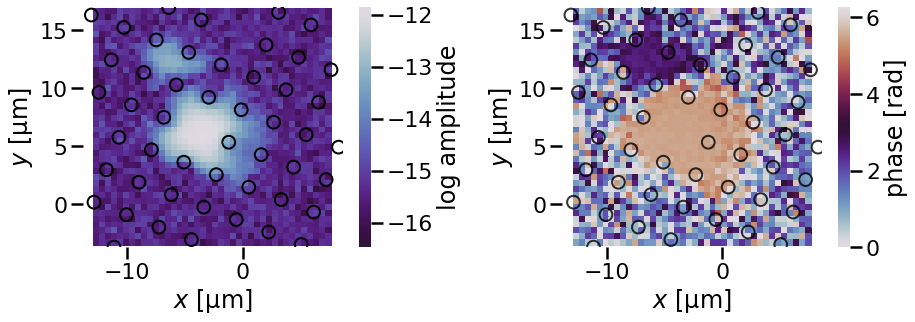

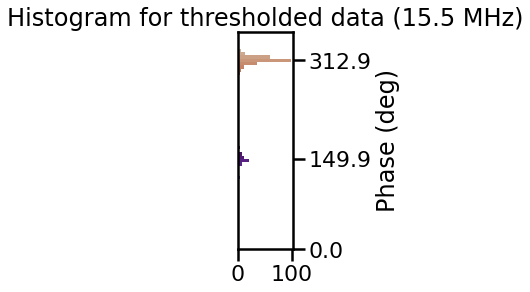

In [9]:
file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum_15.16MHz_1104325' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 

df['X um']=df['Green X']
df['Y um']= df['Green Y']
# calculate corrected phase
df['phase_cor'] = df.phase + radians_correction(df.frequency[0]) ## correction for radians
df['phase_cor_wrap'] = df.phase_cor % (2 * np.pi)

df.rnorm = df.r/df.r.max()
df.phasedeg_uncor = np.rad2deg(df.phase)
df.phasedeg = np.rad2deg(df.phase_cor_wrap)
#display(df.head())
df1516 = df.copy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1) 

amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log10(amp1)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.sca(ax2) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase_cor_wrap').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase [rad]', vmin=0, vmax = 2*np.pi, cmap=divergingcmap);
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)
        
plt.tight_layout();


"""plt.figure()
maskplot(df, mkbackg, 'phase_cor_wrap', cmap = divergingcmap)
plt.title(file)"""

# Phase histogram 1
df.phasedeg_uncor = np.rad2deg(df.phase) ## uncorrected
df.phasedeg = np.rad2deg(df.phase_cor_wrap) ## corrected
plt.figure(figsize=(1,4))
mk = mk1516;
n, bins, patches = plt.hist(df.phasedeg[mk], bins=numbins,color=('#276419'), orientation='horizontal', range=degreerange);
plt.ylabel('Phase (deg)')
#plt.xlabel('# pixels')
### select R12 and R3 from the foreground pixels
maskR12 = (df.phasedeg_uncor[mk] > 0) & (df['Green X'][mk] < 6)
maskR3 = (df.phasedeg_uncor[mk] < 0) & (df['Green Y'][mk] > 0)
print (df.phasedeg[mk][maskR12].mean())
print (df.phasedeg[mk][maskR3].mean())
plt.yticks([df.phasedeg[mk][maskR12].mean() ,0, df.phasedeg[mk][maskR3].mean()])
plt.ylim(degreerange)
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
print("Phase difference (deg):")
print (df.phasedeg[mk][maskR3].mean() - df.phasedeg[mk][maskR12].mean())

## color bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_centers = includeendpoints(bin_centers) # the endpoints are set by degreerange.
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
cm = plt.cm.get_cmap(divergingcmap)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

plt.figure()
plt.title(file)
maskplot(df[mk], maskR3, 'phase_cor_wrap' )    
    
plt.figure()
plt.title(file)
maskplot(df[mk], maskR12, 'phase_cor_wrap' )

print('Mean, first peak:')
print (df.phasedeg[mk][maskR12].mean())
print("Standard dev:")
print (df.phasedeg[mk][maskR12].std())
print("Standard error:")
sterr = df.phasedeg[mk][maskR12].std()/np.sqrt(len(df.phasedeg[mk][maskR12]))
print(sterr)
print("Second peak mean:")
print (df.phasedeg[mk][maskR3].mean())
print("Standard dev:")
print (df.phasedeg[mk][maskR3].std())
print("Stderr:")
stderr2= df.phasedeg[mk][maskR3].std()/np.sqrt(len(df.phasedeg[mk][maskR3]))
print(stderr2)
print("Phase difference (deg): " + str(df.phasedeg[mk][maskR3].mean() - df.phasedeg[mk][maskR12].mean()) + " ± " + str(np.sqrt(sterr**2+stderr2**2)));

"""
plt.figure()
y1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'y').sort_index(axis = 0, ascending = False) 

myheatmap(y1, 'y') 
#          cmap=divergingcmap);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='w', fill = None, alpha = .5)
        plt.gca().add_artist(thiscircle)


plt.figure()
x1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'x').sort_index(axis = 0, ascending = False) 

myheatmap(x1, 'x') 
#          cmap=divergingcmap);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)


plt.figure()
myheatmap(-np.log(-x1), '-log -x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.figure()
myheatmap(np.log(x1), 'log x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)
"""
        
file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1_15.5MHz105133' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']
# calculate corrected phase
df['phase_cor'] = df.phase + radians_correction(df.frequency[0]) ## correction for radians
df['phase_cor_wrap'] = df.phase_cor % (2 * np.pi)

df1550 = df.copy()


fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(13.23,5))

plt.sca(ax3)
amp2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log(amp2)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax3.axis('equal');

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = 1)
        plt.gca().add_artist(thiscircle)

plt.sca(ax4)
phase2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase_cor_wrap').sort_index(axis = 0, ascending = False) 
myheatmap(phase2, 'phase [rad]',vmin=0, vmax = 2* np.pi, cmap=divergingcmap);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax4.axis('equal');

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.tight_layout();

# Phase histogram 2
df.phasedeg_uncor = np.rad2deg(df.phase)
df.phasedeg = np.rad2deg(df.phase_cor_wrap)
df.rnorm = df.r/df.r.max()
print("rmax = " + str(df.r.max()))
plt.figure(figsize=(1,4))
#mk1550 = df.rnorm > backgthresh1550;
n, bins, patches = plt.hist(df.phasedeg[mk1550], bins=numbins,color=('#276419'),orientation='horizontal', range=degreerange);
plt.ylabel('Phase (deg)')
plt.title('Histogram for thresholded data (15.5 MHz)')
#plt.xlabel('# pixels')
## use uncorrected phase for calculating the mask
maskR2 = (df.phasedeg_uncor[mk1550] > 0) & (df['Green Y'][mk1550] > 7.0) & (df['Green X'][mk1550] < 0.0) & (df['Green X'][mk1550] > -10.5)
maskR1 = (df.phasedeg_uncor[mk1550] < 0) & (df['Green X'][mk] > -10)
print (df.phasedeg[mk1550][maskR2].mean())
print (df.phasedeg[mk1550][maskR1].mean())
plt.yticks([df.phasedeg[mk1550][maskR2].mean(), 0,df.phasedeg[mk1550][maskR1].mean() ])
plt.ylim(degreerange)
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
print("Phase difference (deg):")
print (df.phasedeg[mk1550][maskR1].mean() - df.phasedeg[mk1550][maskR2].mean())
## color bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_centers=includeendpoints(bin_centers) # the endpoints are set by degreerange.
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
cm = plt.cm.get_cmap(divergingcmap)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
    
"""plt.figure()
maskplot(df, mk1550, 'phase_cor_wrap',cmap='viridis')    
plt.title(file)

plt.figure()
maskplot(df[mk1550], maskR2, 'phase_cor_wrap',cmap='viridis')
plt.title(file + 'resonator 2')

plt.figure()
maskplot(df1516, mk1550, 'phase_cor_wrap',cmap='viridis' )
plt.title('15.16 MHz, foreground of 15.50 MHz')

plt.figure()
maskplot(df1516[mk1550], maskR1, 'phase_cor_wrap',cmap='viridis')
plt.title('15.16 MHz, resonator 1')

plt.figure()
maskplot(df1516[mk1550], maskR2, 'phase_cor_wrap',cmap='viridis')
plt.title('15.16 MHz, resonator 2')


"""
#df1516[mk][maskR2]

"""
plt.figure()
x1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'x').sort_index(axis = 0, ascending = False) 

myheatmap(x1, 'x', 
          cmap=divergingcmap);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)
        

plt.figure()
myheatmap(np.log(-x1), 'log -x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)


plt.figure()
myheatmap(np.log(x1), 'log x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)
""";


In [10]:
print('resonator 1 average amplitude at 15.16 MHz: ' 
      + str(np.mean(df1516[mk1550][maskR1].r)) + ' ± ' 
      + str(np.std(df1516[mk1550][maskR1].r) / np.sqrt(len(df1516[mk1550][maskR1].r))))
print('resonator 1 max amplitude at 15:16 MHz: '
     + str(np.max(df1516[mk1550][maskR1].r)))
print('resonator 1 UNCORRECTED average phase at 15.16 MHz: ' 
      + str(np.mean(df1516[mk1550][maskR1].phase)) + ' rad')
print('resonator 1 corrected average phase at 15.16 MHz: ' 
      + str(np.mean(df1516[mk1550][maskR1].phase_cor)) + ' rad')
unc1_uncor = np.std(df1516[mk1550][maskR1].phase)/np.sqrt(len(df1516[mk1550][maskR1].phase))
unc1_cor = np.std(df1516[mk1550][maskR1].phase_cor)/np.sqrt(len(df1516[mk1550][maskR1].phase_cor))
print('resonator 1 UNCORRECTED average phase at 15.16 MHz: ' 
      + str(np.mean(df1516[mk1550][maskR1].phase) * 180/np.pi) 
      + ' ± ' 
      + str( unc1_uncor * 180/np.pi ) 
      + ' deg')
print('resonator 1 average phase at 15.16 MHz: ' 
      + str(np.mean(df1516[mk1550][maskR1].phase_cor) * 180/np.pi) 
      + ' ± ' 
      + str( unc1_cor * 180/np.pi ) 
      + ' deg')

print('resonator 2 average amplitude at 15.16 MHz: ' 
      + str(np.mean(df1516[mk1550][maskR2].r))
      + ' ± '
      + str(np.std(df1516[mk1550][maskR2].r) / np.sqrt(len(df1516[mk1550][maskR2].r))) )
print('resonator 2 max amplitude at 15.16 MHz: '
     + str(np.max(df1516[mk1550][maskR2].r)))
print('max A2 / max A1: '
     + str((np.max(df1516[mk1550][maskR2].r))/ (np.max(df1516[mk1550][maskR1].r))))
print('resonator 2 UNCORRECTED average phase at 15.16 MHz: ' 
      + str(np.mean(df1516[mk1550][maskR2].phase))+ ' rad')
print('resonator 2 average phase at 15.16 MHz: ' 
      + str(np.mean(df1516[mk1550][maskR2].phase_cor))+ ' rad')
unc2_uncor = np.std(df1516[mk1550][maskR2].phase)/(np.sqrt(len(df1516[mk1550][maskR2].phase)))
unc2_cor = np.std(df1516[mk1550][maskR2].phase_cor)/(np.sqrt(len(df1516[mk1550][maskR2].phase_cor)))
print('resonator 2 UNCORRECTED average phase at 15.16 MHz: ' 
      + str(np.mean(df1516[mk1550][maskR2].phase) * 180/np.pi)
      + ' ± '
      + str(unc2_uncor * 180/np.pi)
      + ' deg')
print('resonator 2 average phase at 15.16 MHz: ' 
      + str(np.mean(df1516[mk1550][maskR2].phase_cor) * 180/np.pi)
      + ' ± '
      + str(unc2_cor * 180/np.pi)
      + ' deg')

print('UNCORRECTED Phase difference $\delta_{12}$ at 15.16 MHz: ' 
     + str((np.mean(df1516[mk1550][maskR2].phase) - np.mean(df1516[mk1550][maskR1].phase)) * 180/np.pi)
     + ' ± '
     + str(np.sqrt(unc1_uncor**2 + unc2_uncor**2) * 180/np.pi)
     + ' deg\n')
print('CORRECTED Phase difference $\delta_{12}$ at 15.16 MHz: ' 
     + str((np.mean(df1516[mk1550][maskR2].phase_cor) - np.mean(df1516[mk1550][maskR1].phase_cor)) * 180/np.pi)
     + ' ± '
     + str(np.sqrt(unc1_cor**2 + unc2_cor**2) * 180/np.pi)
     + ' deg\n')

print('resonator 3 average amplitude at 15.16 MHz: ' 
      + str(np.mean(df1516[mk1516][maskR3].r))
      + ' ± '
      + str(np.std(df1516[mk1516][maskR3].r) / np.sqrt(len(df1516[mk1516][maskR3].r))) )
print('resonator 3 max amplitude at 15.16 MHz: '
     + str(np.max(df1516[mk1516][maskR3].r)))
print('max A3 / max A1: '
     + str((np.max(df1516[mk1516][maskR3].r))/ (np.max(df1516[mk1550][maskR1].r))))
print('max A3 / max A2: '
     + str((np.max(df1516[mk1516][maskR3].r))/ (np.max(df1516[mk1550][maskR2].r))))
print('resonator 3 UNCORRECTED average phase at 15.16 MHz: ' 
      + str(np.mean(df1516[mk1516][maskR3].phase))+ ' rad')
print('resonator 3 corrected average phase at 15.16 MHz: ' 
      + str(np.mean(df1516[mk1516][maskR3].phase_cor))+ ' rad')
unc3_uncor = np.std(df1516[mk1516][maskR3].phase)/(np.sqrt(len(df1516[mk1516][maskR3].phase)))
unc3_cor = np.std(df1516[mk1516][maskR3].phase_cor)/(np.sqrt(len(df1516[mk1516][maskR3].phase_cor)))
print('resonator 3 UNCORRECTED average phase at 15.16 MHz: ' 
      + str(np.mean(df1516[mk1516][maskR3].phase) * 180/np.pi)
      + ' ± '
      + str(unc3_uncor * 180/np.pi)
      + ' deg\n')
print('resonator 3 corrected average phase at 15.16 MHz: ' 
      + str(np.mean(df1516[mk1516][maskR3].phase_cor) * 180/np.pi)
      + ' ± '
      + str(unc3_cor * 180/np.pi)
      + ' deg\n')

print('resonator 1 average amplitude at 15.50 MHz: ' 
      + str(np.mean(df1550[mk1550][maskR1].r)) + ' ± ' 
      + str(np.std(df1550[mk1550][maskR1].r) / np.sqrt(len(df1550[mk1550][maskR1].r))))
print('resonator 1 max amplitude at 15.50 MHz: '
     + str(np.max(df1550[mk1550][maskR1].r)))
print('resonator 1 UNCORRECTED average phase at 15.50 MHz: ' 
      + str(np.mean(df1550[mk1550][maskR1].phase)) + ' rad')
print('resonator 1 corrected average phase at 15.50 MHz: ' 
      + str(np.mean(df1550[mk1550][maskR1].phase_cor)) + ' rad')
unc1_uncor = np.std(df1550[mk1550][maskR1].phase)/np.sqrt(len(df1550[mk1550][maskR1].phase))
unc1_cor = np.std(df1550[mk1550][maskR1].phase_cor)/np.sqrt(len(df1550[mk1550][maskR1].phase_cor))
print('resonator 1 UNCORRECTED average phase at 15.50 MHz: ' 
      + str(np.mean(df1550[mk1550][maskR1].phase) * 180/np.pi) 
      + ' ± ' 
      + str( unc1_uncor * 180/np.pi ) 
      + ' deg')
print('resonator 1 corrected average phase at 15.50 MHz: ' 
      + str(np.mean(df1550[mk1550][maskR1].phase_cor) * 180/np.pi) 
      + ' ± ' 
      + str( unc1_cor * 180/np.pi ) 
      + ' deg')

print('resonator 2 average amplitude at 15.50 MHz: ' 
      + str(np.mean(df1550[mk1550][maskR2].r))
      + ' ± '
      + str(np.std(df1550[mk1550][maskR2].r) / np.sqrt(len(df1550[mk1550][maskR2].r))))
print('resonator 2 max amplitude at 15.50 MHz: '
     + str(np.max(df1550[mk1550][maskR2].r)))
print('resonator 2 UNCORRECTED average phase at 15.50 MHz: ' 
      + str(np.mean(df1550[mk1550][maskR2].phase))+ ' rad')
print('resonator 2 corrected average phase at 15.50 MHz: ' 
      + str(np.mean(df1550[mk1550][maskR2].phase_cor))+ ' rad')
unc2_uncor = np.std(df1550[mk1550][maskR2].phase)/(np.sqrt(len(df1550[mk1550][maskR2].phase)))
unc2_cor = np.std(df1550[mk1550][maskR2].phase_cor)/(np.sqrt(len(df1550[mk1550][maskR2].phase_cor)))
print('resonator 2 UNCORRECTED average phase at 15.50 MHz: ' 
      + str(np.mean(df1550[mk1550][maskR2].phase) * 180/np.pi)
      + ' ± '
      + str(unc2_uncor * 180/np.pi)
      + ' deg')
print('resonator 2 CORRECTED average phase at 15.50 MHz: ' 
      + str(np.mean(df1550[mk1550][maskR2].phase_cor) * 180/np.pi)
      + ' ± '
      + str(unc2_cor * 180/np.pi)
      + ' deg')

print('UNCORRECTED Phase difference $\delta_{12}$ at 15.50 MHz: ' 
     + str((np.mean(df1550[mk1550][maskR2].phase) - np.mean(df1550[mk1550][maskR1].phase)) * 180/np.pi)
     + ' ± '
     + str(np.sqrt(unc1_uncor**2 + unc2_uncor**2) * 180/np.pi)
     + ' deg\n')
print('Corrected Phase difference $\delta_{12}$ at 15.50 MHz: ' 
     + str((np.mean(df1550[mk1550][maskR2].phase_cor) - np.mean(df1550[mk1550][maskR1].phase_cor)) * 180/np.pi)
     + ' ± '
     + str(np.sqrt(unc1_cor**2 + unc2_cor**2) * 180/np.pi)
     + ' deg\n')

print('resonator 3 average amplitude at 15.50 MHz: ' 
      + str(np.mean(df1550[mk1516][maskR3].r))
      + ' ± '
      + str(np.std(df1550[mk1516][maskR3].r) / np.sqrt(len(df1550[mk1516][maskR3].r))) )
print('resonator 3 max amplitude at 15.50 MHz: '
     + str(np.max(df1550[mk1516][maskR3].r)))
print('resonator 3 UNCORRECTED average phase at 15.50 MHz: ' 
      + str(np.mean(df1550[mk1516][maskR3].phase))+ ' rad')
print('resonator 3 corrected average phase at 15.50 MHz: ' 
      + str(np.mean(df1550[mk1516][maskR3].phase_cor))+ ' rad')
unc3_uncor = np.std(df1550[mk1516][maskR3].phase)/(np.sqrt(len(df1550[mk1516][maskR3].phase)))
unc3_cor = np.std(df1550[mk1516][maskR3].phase_cor)/(np.sqrt(len(df1550[mk1516][maskR3].phase_cor)))

print('resonator 3 UNCORRECTED average phase at 15.50 MHz: ' 
      + str(np.mean(df1550[mk1516][maskR3].phase) * 180/np.pi)
      + ' ± '
      + str(unc2_uncor * 180/np.pi)
      + ' deg')
print('resonator 3 corrected average phase at 15.50 MHz: ' 
      + str(np.mean(df1550[mk1516][maskR3].phase_cor) * 180/np.pi)
      + ' ± '
      + str(unc2_cor * 180/np.pi)
      + ' deg')

resonator 1 average amplitude at 15.16 MHz: 8.250754032258065e-06 ± 3.8477181726212165e-07
resonator 1 max amplitude at 15:16 MHz: 2.25e-05
resonator 1 UNCORRECTED average phase at 15.16 MHz: 2.279326554036291 rad
resonator 1 corrected average phase at 15.16 MHz: -1.3764655509041412 rad
resonator 1 UNCORRECTED average phase at 15.16 MHz: 130.59579167837703 ± 0.4572849443916407 deg
resonator 1 average phase at 15.16 MHz: -78.86566671195706 ± 0.45728494439164075 deg
resonator 2 average amplitude at 15.16 MHz: 1.688154411764706e-05 ± 1.3682407028232933e-06
resonator 2 max amplitude at 15.16 MHz: 4.1342e-05
max A2 / max A1: 1.837422222222222
resonator 2 UNCORRECTED average phase at 15.16 MHz: 1.9034405732205883 rad
resonator 2 average phase at 15.16 MHz: -1.7523515317198433 rad
resonator 2 UNCORRECTED average phase at 15.16 MHz: 109.05911139950187 ± 1.1079683416559964 deg
resonator 2 average phase at 15.16 MHz: -100.40234699083223 ± 1.1079683416559967 deg
UNCORRECTED Phase difference $\del

<ipython-input-10-55bdd7b20776>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  + str(np.mean(df1516[mk1550][maskR1].r)) + ' ± '
<ipython-input-10-55bdd7b20776>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  + str(np.std(df1516[mk1550][maskR1].r) / np.sqrt(len(df1516[mk1550][maskR1].r))))
<ipython-input-10-55bdd7b20776>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  + str(np.max(df1516[mk1550][maskR1].r)))
<ipython-input-10-55bdd7b20776>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  + str(np.mean(df1516[mk1550][maskR1].phase)) + ' rad')
<ipython-input-10-55bdd7b20776>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  + str(np.mean(df1516[mk1550][maskR1].phase_cor)) + ' rad')
<ipython-input-10-55bdd7b20776>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unc1_uncor = np.std(df1516[mk1550][

<ipython-input-11-463eddd9bcc6>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.phasedeg_uncor = np.rad2deg(df.phase)
<ipython-input-11-463eddd9bcc6>:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.phasedeg = np.rad2deg(df.phase_cor_wrap)
<ipython-input-11-463eddd9bcc6>:38: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.phasedeg_uncor = np.rad2deg(df.phase)
<ipython-input-11-463eddd9bcc6>:39: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.phasedeg = np.rad2deg(df.phase_cor_wrap)


Resonators12 phase 274.7901482773674
Resonator 3 phase 93.99804761333851
Phase difference (deg):
-180.79210066402888
Resonator 2 phase 149.86683850789393
Resonator 1 phase 312.9498215448236
Phase difference (deg):
163.08298303692965


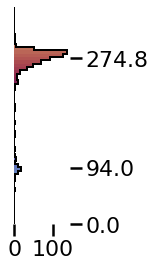

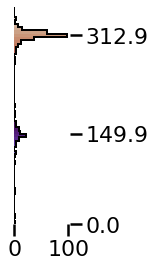

In [11]:
mk = mk1516;
df = df1516;
df.phasedeg_uncor = np.rad2deg(df.phase)
df.phasedeg = np.rad2deg(df.phase_cor_wrap)



plt.figure(figsize=(1,4))

plt.hist(df.phasedeg[mk], bins=numbins,color=('k'),orientation='horizontal', histtype='step', range=degreerange);
n, bins, patches = plt.hist(df.phasedeg[mk], bins=numbins, orientation='horizontal', range=degreerange);
#plt.ylabel('Phase (deg)')
#plt.xlabel('# pixels')
print ('Resonators12 phase ' + str(df.phasedeg[mk][maskR12].mean()))
print ('Resonator 3 phase ' + str(df.phasedeg[mk][maskR3].mean()))
plt.yticks([df.phasedeg[mk][maskR12].mean() ,0, df.phasedeg[mk][maskR3].mean()])
plt.ylim(degreerange)
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
print("Phase difference (deg):")
print (df.phasedeg[mk][maskR3].mean() - df.phasedeg[mk][maskR12].mean())

## color bins, https://stackoverflow.com/questions/23061657/plot-histogram-with-colors-taken-from-colormap
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_centers=includeendpoints(bin_centers)
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
cm = plt.cm.get_cmap(divergingcmap)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
sns.despine(left=True, right=True, bottom=True)    
    

mk = mk1550;
df = df1550;
df.phasedeg_uncor = np.rad2deg(df.phase)
df.phasedeg = np.rad2deg(df.phase_cor_wrap)

      
plt.figure(figsize=(1,4))
plt.hist(df.phasedeg[mk], bins=numbins,color=('k'),orientation='horizontal', histtype='step', range=degreerange);
n, bins, patches = plt.hist(df.phasedeg[mk], bins=numbins,orientation='horizontal', range=degreerange);
#plt.ylabel('Phase (deg)')
#plt.xlabel('# pixels')
print ('Resonator 2 phase ' + str(df.phasedeg[mk][maskR2].mean()))
print ('Resonator 1 phase ' + str(df.phasedeg[mk][maskR1].mean()))
plt.yticks([df.phasedeg[mk][maskR2].mean(), 0,df.phasedeg[mk][maskR1].mean() ])
plt.ylim(degreerange)
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
print("Phase difference (deg):")
print (df.phasedeg[mk][maskR1].mean() - df.phasedeg[mk][maskR2].mean())
## color bins, https://stackoverflow.com/questions/23061657/plot-histogram-with-colors-taken-from-colormap
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_centers=includeendpoints(bin_centers)
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
cm = plt.cm.get_cmap(divergingcmap)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
sns.despine(left=True, right=True, bottom=True)

In [12]:
"""mk = mk1516;
df = df1516;

plt.figure(figsize=(1,4))

plt.hist(df.phasedeg[mk], bins=numbins,color=('k'),orientation='horizontal', histtype='step', range=degreerange);
n, bins, patches = plt.hist(df.phasedeg[mk], bins=numbins, orientation='horizontal', range=degreerange);
#plt.ylabel('Phase (deg)')
#plt.xlabel('# pixels')
print ('Resonators12 phase ' + str(df.phasedeg[mk][maskR12].mean()))
print ('Resonator 3 phase ' + str(df.phasedeg[mk][maskR3].mean()))
plt.yticks([df.phasedeg[mk][maskR12].mean() ,0, df.phasedeg[mk][maskR3].mean()])
plt.ylim(degreerange)
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
print("Phase difference (deg):")
print (df.phasedeg[mk][maskR3].mean() - df.phasedeg[mk][maskR12].mean())

## color bins, https://stackoverflow.com/questions/23061657/plot-histogram-with-colors-taken-from-colormap
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_centers=includeendpoints(bin_centers)
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
cm = plt.cm.get_cmap(divergingcmap)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
sns.despine(left=True, right=True, bottom=True)    
    

mk = mk1550;
df = df1550;
      
plt.figure(figsize=(1,4))
plt.hist(df.phasedeg[mk], bins=numbins,color=('k'),orientation='horizontal', histtype='step', range=degreerange);
n, bins, patches = plt.hist(df.phasedeg[mk], bins=numbins,orientation='horizontal', range=degreerange);
#plt.ylabel('Phase (deg)')
#plt.xlabel('# pixels')
print ('Resonator 2 phase ' + str(df.phasedeg[mk][maskR2].mean()))
print ('Resonator 1 phase ' + str(df.phasedeg[mk][maskR1].mean()))
plt.yticks([df.phasedeg[mk][maskR2].mean(), 0,df.phasedeg[mk][maskR1].mean() ])
plt.ylim(degreerange)
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
print("Phase difference (deg):")
print (df.phasedeg[mk][maskR1].mean() - df.phasedeg[mk][maskR2].mean())
## color bins, https://stackoverflow.com/questions/23061657/plot-histogram-with-colors-taken-from-colormap
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_centers=includeendpoints(bin_centers)
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
cm = plt.cm.get_cmap(divergingcmap)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
sns.despine(left=True, right=True, bottom=True)""";

<ipython-input-13-9d1777893470>:21: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.phasedeg_uncor = np.rad2deg(df.phase)
<ipython-input-13-9d1777893470>:22: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.phasedeg = np.rad2deg(df.phase_cor_wrap)
<ipython-input-13-9d1777893470>:23: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.rnorm = df.r/df.r.max()


Resonators12 phase 274.7901482773674
Resonator 3 phase 93.99804761333851
Phase difference (deg):
-180.79210066402888
Frequency in Hz:  15510020.04007998


<ipython-input-13-9d1777893470>:160: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.rnorm = df.r/df.r.max()
<ipython-input-13-9d1777893470>:167: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.phasedeg_uncor = np.rad2deg(df.phase)
<ipython-input-13-9d1777893470>:168: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.phasedeg = np.rad2deg(df.phase_cor_wrap)


Resonator 2 phase 149.86683850789393
Resonator 1 phase 312.9498215448236
Phase difference (deg):
163.08298303692965
File not overwritten:
\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Papers and Abstracts\Coupled Resonator Spatial Imaging\Figures\python_exports\modemap_export.pdf
File not overwritten:
\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Papers and Abstracts\Coupled Resonator Spatial Imaging\Figures\python_exports\circles_export.pdf


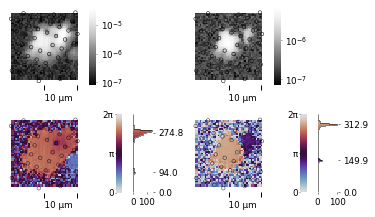

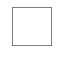

In [13]:
sns.set_context('paper') # makes text sized for paper

#saving = True
add_circle= True
rotating = True
#divergingcmap = 'twilight_shifted'
ampcmap = 'Greys_r' #'magma'

file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum_15.16MHz_1104325' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 

df['X um']=df['Green X']
df['Y um']= df['Green Y']
# calculate corrected phase
df['phase_cor'] = df.phase + radians_correction(df.frequency[0]) ## correction for radians
df['phase_cor_wrap'] = df.phase_cor % (2 * np.pi)

df.phasedeg_uncor = np.rad2deg(df.phase)
df.phasedeg = np.rad2deg(df.phase_cor_wrap)
df.rnorm = df.r/df.r.max()

widths = [2.6,.7,2.6,.7]
heights = [1, 1]
gs_kw = dict(width_ratios=widths, height_ratios=heights)

## (2,2) size.   #3.37, 2.8 is tight; 3.15 height gives space for scale bar.
sty={'figsize':(5.1,2.9), "constrained_layout":True, "gridspec_kw": gs_kw}

## (1,2) size
#sty={'figsize':(3.37,1.43), "constrained_layout":True}



fig, ((ax1, blank1, ax2, blank2),(ax3, phist1, ax4, phist2)) = plt.subplots(2,4, **sty)
#fig, (ax3, ax4) = plt.subplots(1, 2, **sty)

blank1.axis('off')
blank2.axis('off')


## label text for scalebar
tenum = u'\u200c          10 μm'

#plt.suptitle(file + '\n\n');
plt.sca(ax1) 

amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log10(amp1)
if rotating:
    data = rotatehack(data)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

#axx,cbar = myheatmap(data,  norm = greennorm, return_cbar=True,
#          cmap=cmapforhalf);
axx,cbar = myheatmap(data,   return_cbar=True,
          cmap=ampcmap);
plt.xlabel('')
plt.ylabel('')
ax1.axis('equal')
topx = data.columns.max()
plt.xticks([topx-10, topx])
plt.gca().set_xticklabels([tenum, ''])
plt.yticks([]) # remove y ticks, since we can use the xticks alone on a square plot
cbar1 = cbar

# decrease number of ticks on colorbar
"""tick_locator = mpl.ticker.MaxNLocator(nbins=4)
cbar.locator = tick_locator
cbar.update_ticks()"""
#cbar.set_ticks([-11, -16])
cbar.set_ticks([-7, -6,-5])
cbar.ax.set_yticklabels(['$10^{-7}$', '$10^{-6}$','$10^{-5}$']) ## make SURE this line is with the one above it
ylims = plt.ylim()
xlims = plt.xlim()

if add_circle:
    if rotating:
        coordinateslist = coordlistrot
    else:
        coordinateslist = coordlist
    for coords in coordinateslist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = 1, lw=0.5,)#linestyle='dashed')
        plt.gca().add_artist(thiscircle)

plt.sca(ax3) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase_cor_wrap').sort_index(axis = 0, ascending = False) 
data = phase1
if rotating:
    data = rotatehack(data)
axx, cbar = myheatmap(data, return_cbar=True,  vmin=0, vmax = 2*np.pi, cmap=divergingcmap);
ax2.axis('equal');
plt.xlabel('')
plt.ylabel('')
#topx = amp1.columns.max()
plt.xticks([topx-10, topx])
plt.gca().set_xticklabels([tenum, ''])
cbar.ax.yaxis.set_ticks_position('left')
cbar.set_ticks([0, np.pi,2*np.pi])
cbar.ax.set_yticklabels([ '0', '\u03C0','2\u03C0'],ha='right')  # make sure this line is joined with the one above it.
cbar.ax.yaxis.set_tick_params(pad=1)  # your number may vary
plt.yticks([]) # remove y ticks, since we can use the xticks alone on a square plot
cbar2 = cbar

if add_circle:
    if rotating:
        coordinateslist = coordlistrot
    else:
        coordinateslist = coordlist
    for coords in coordinateslist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8, lw=0.5,)#linestyle='dashed')
        plt.gca().add_artist(thiscircle)
        
plt.sca(phist1) # Phase histogram 1
mk = mk1516;
plt.hist(df.phasedeg[mk], bins=numbins,color=('k'),orientation='horizontal', 
         histtype='step', range=degreerange, linewidth = 0.5);
n, bins, patches = plt.hist(df.phasedeg[mk], bins=numbins, orientation='horizontal', range=degreerange);
#plt.ylabel('Phase (deg)')
#plt.xlabel('# pixels')
print ('Resonators12 phase ' + str(df.phasedeg[mk][maskR12].mean()))
print ('Resonator 3 phase ' + str(df.phasedeg[mk][maskR3].mean()))
plt.yticks([df.phasedeg[mk][maskR12].mean() ,0, df.phasedeg[mk][maskR3].mean()])
plt.ylim(degreerange)
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
print("Phase difference (deg):")
print (df.phasedeg[mk][maskR3].mean() - df.phasedeg[mk][maskR12].mean())

## color bins, https://stackoverflow.com/questions/23061657/plot-histogram-with-colors-taken-from-colormap
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_centers=includeendpoints(bin_centers)
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
cm = plt.cm.get_cmap(divergingcmap)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

#plt.tight_layout();
"""if saving:
    plt.savefig(os.path.join(savefolder,file + '.pdf'), dpi=None, facecolor='w', edgecolor='w',
        transparent=False, bbox_inches='tight', pad_inches=0.05,
        metadata=None)"""



file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1_15.5MHz105133' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
 
df['X um']=df['Green X']
df['Y um']= df['Green Y']
df.rnorm = df.r/df.r.max()        

print("Frequency in Hz: ",df.frequency[0])
# phase correction
df['phase_cor'] = df.phase + radians_correction(df.frequency[0]) ## correction for radians
df['phase_cor_wrap'] = df.phase_cor % (2 * np.pi)

df.phasedeg_uncor = np.rad2deg(df.phase)
df.phasedeg = np.rad2deg(df.phase_cor_wrap)


plt.sca(ax2)
amp2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log10(amp2)
if rotating:
    data = rotatehack(data)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

#axx, cbar = myheatmap(data,  norm = greennorm, return_cbar=True,
#          cmap=cmapforhalf);
axx, cbar = myheatmap(data,  return_cbar=True,
          cmap=ampcmap);
plt.xlabel('')
plt.ylabel('')
ax3.axis('equal');
#topx = amp1.columns.max()
plt.xticks([topx-10, topx])
plt.gca().set_xticklabels([tenum, ''])
plt.yticks([]) # remove y ticks, since we can use the xticks alone on a square plot

# decrease number of ticks on colorbar
#cbar.ax.locator_params(nbins=2)
#cbar.set_ticks([-12,-16])
cbar.set_ticks([-7, -6,-5])
cbar.ax.set_yticklabels(['$10^{-7}$', '$10^{-6}$','$10^{-5}$']) ## make SURE this line is with the one above it
cbar3= cbar

if add_circle:
    if rotating:
        coordinateslist = coordlistrot
    else:
        coordinateslist = coordlist
    for coords in coordinateslist:        
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = 1, lw=0.5,)#linestyle='dashed')
        plt.gca().add_artist(thiscircle)

plt.sca(ax4)
phase2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase_cor_wrap').sort_index(axis = 0, ascending = False) 
data = phase2
if rotating:
    data = rotatehack(data)
axx, cbar = myheatmap(data, return_cbar=True, vmin=0, vmax = 2*np.pi, cmap=divergingcmap);
plt.xlabel('')
plt.ylabel('')
ax4.axis('equal');
#topx = amp1.columns.max()
plt.xticks([topx-10, topx])
plt.gca().set_xticklabels([tenum, ''])
plt.yticks([]) # remove y ticks, since we can use the xticks alone on a square plot
cbar.ax.yaxis.set_ticks_position('left')
cbar.set_ticks([ 0, np.pi, 2*np.pi])
cbar.ax.set_yticklabels([ '0', '\u03C0', '2\u03C0'],ha='right')  # make sure this line is joined with the one above it.
cbar.ax.yaxis.set_tick_params(pad=1)  # your number may vary
cbar4 = cbar


for cbar in [cbar1, cbar2, cbar3, cbar4]:
    cbar.ax.tick_params(length=cbarticklength, width=tickwidth)


# add_sizebar(ax4, 10) # creates a scalebar a little bit covering the plot.

if add_circle:
    if rotating:
        coordinateslist = coordlistrot
    else:
        coordinateslist = coordlist
    for coords in coordinateslist:        
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8, lw=0.5,)#linestyle='dashed')
        plt.gca().add_artist(thiscircle)


mk = mk1550;
         
plt.sca(phist2) # Phase histogram 2
plt.hist(df.phasedeg[mk], bins=numbins,color=('k'),orientation='horizontal', 
         histtype='step', range=degreerange, linewidth=0.5); # outline
n, bins, patches = plt.hist(df.phasedeg[mk], bins=numbins,color=('#276419'),orientation='horizontal', range=degreerange);
#plt.ylabel('Phase (deg)')
#plt.xlabel('# pixels')
print ('Resonator 2 phase ' + str(df.phasedeg[mk][maskR2].mean()))
print ('Resonator 1 phase ' + str(df.phasedeg[mk][maskR1].mean()))
plt.yticks([df.phasedeg[mk][maskR2].mean(), 0,df.phasedeg[mk][maskR1].mean() ])
plt.ylim(degreerange)
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
print("Phase difference (deg):")
print (df.phasedeg[mk][maskR1].mean() - df.phasedeg[mk][maskR2].mean())
## color bins, https://stackoverflow.com/questions/23061657/plot-histogram-with-colors-taken-from-colormap
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_centers=includeendpoints(bin_centers)
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
cm = plt.cm.get_cmap(divergingcmap)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
sns.despine(left=True, right=True, bottom=True)


for ax in [phist1, phist2]:
    ax.tick_params(direction='out', length=ticklength, width=tickwidth)
        
#plt.tight_layout();

bbox1 = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
heatmapsize = (bbox1.width, bbox1.height)


if saving:
    plt.savefig(os.path.join(savefolder, 'modemap_export.pdf'), dpi=None, facecolor='w',  edgecolor='w',
        transparent=False, bbox_inches='tight', pad_inches=0,
        metadata=None)
    print('File saved: ')
else:
    print('File not overwritten:')
print(os.path.join(savefolder, 'modemap_export.pdf'))

#saving = True
add_circle= True

#plt.figure(figsize=(1,1))
plt.figure(figsize=(.7,.7))

plt.xlim(xlims)
plt.ylim(ylims)
plt.gca().axis('equal');
plt.xlabel('')
plt.ylabel('')
#topx = amp1.columns.max()
## 10 um measure-bar
#plt.xticks([topx-10, topx])
#plt.gca().set_xticklabels([tenum, ''])
## no x-ticks
plt.xticks([]) # no sizing
plt.yticks([]) # remove y ticks, since we can use the xticks alone on a square plot

if add_circle:
    if rotating:
        coordinateslist = coordlistrot
    else:
        coordinateslist = coordlist
    for coords in coordinateslist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8, lw=0.5,)#linestyle='dashed')
        plt.gca().add_artist(thiscircle)

for _,s in plt.gca().spines.items():
        s.set_linewidth(.5)
        
#plt.tight_layout();

#saving=True
if saving:
    plt.savefig(os.path.join(savefolder, 'circles_export.pdf'), dpi=None, facecolor='w',  edgecolor='w',
        transparent=False, bbox_inches='tight', pad_inches=0.005,
        metadata=None)
    print('File saved: ')
else:
    print('File not overwritten:')
print(os.path.join(savefolder, 'circles_export.pdf'))

sns.set_context('poster') # makes text larger again

In [14]:
## ~~~~~~~ See above for the plots
display(heatmapsize)

avgsize = sum(list(heatmapsize))/2

(1.1237806324110673, 0.9952272727272728)

<ipython-input-1-3b29350f94bc>:53: RuntimeWarning: divide by zero encountered in double_scalars
  normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
<ipython-input-1-3b29350f94bc>:57: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  return sp.ma.masked_array(sp.interp(value, x, y))
<ipython-input-1-3b29350f94bc>:53: RuntimeWarning: divide by zero encountered in double_scalars
  normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
<ipython-input-1-3b29350f94bc>:57: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  return sp.ma.masked_array(sp.interp(value, x, y))


PosGU01Arrray01.00r0.5p3Device0.0Drum210V_15.6MHz100338


<ipython-input-1-3b29350f94bc>:53: RuntimeWarning: divide by zero encountered in double_scalars
  normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
<ipython-input-1-3b29350f94bc>:57: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  return sp.ma.masked_array(sp.interp(value, x, y))


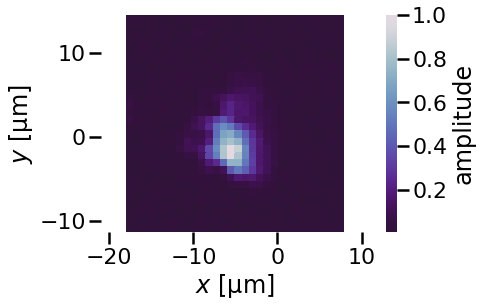

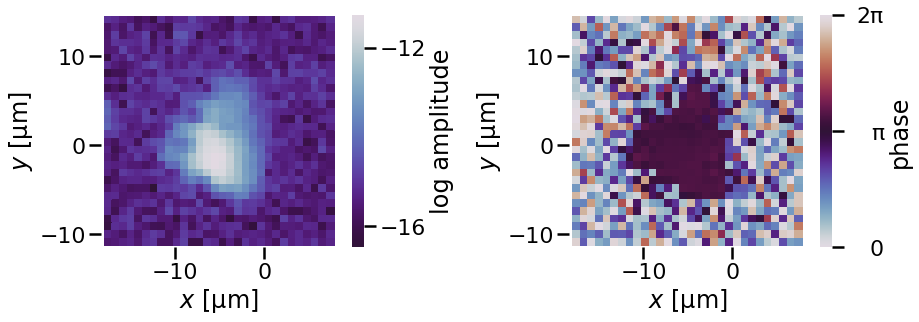

In [15]:
## single resonator

file = 'PosGU01Arrray01.00r0.5p3Device0.0Drum210V_15.6MHz100338' 
path = os.path.join(folder2,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 

df['X um']=df['Green X']
df['Y um']= df['Green Y']
# calculate corrected phase
df['phase_cor'] = df.phase + radians_correction(df.frequency[0]) ## correction for radians
df['phase_cor_wrap'] = df.phase_cor % (2 * np.pi)

plt.figure()
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False)

singleresdata = (amp1)/(amp1.max().max())
max2 = amp1.max().max()
# set white at max, cut colorbar in half
vmin = np.array(singleresdata).min()
vmax = np.array(singleresdata).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

ax, cbar = myheatmap(singleresdata, 'amplitude', norm = greennorm,
                  cmap=cmapforhalf, return_cbar=True);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax.axis('equal')
#cbar.set_ticks([-16,-12])

fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(13.23,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1)
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log(amp1)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

_, cbar1 = myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf, return_cbar=True);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')
cbar1.set_ticks([-16,-12])



plt.sca(ax2) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase_cor_wrap').sort_index(axis = 0, ascending = False) 
_, cbar = myheatmap(phase1, 'phase',vmin=0, vmax = 2*np.pi, cmap=divergingcmap, return_cbar=True);
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
cbar.set_ticks([ 0, np.pi, 2*np.pi])
cbar.ax.set_yticklabels(['0', '\u03C0', '2\u03C0'],ha='right')  # make sure this line is joined with the one above it.
cbar.ax.yaxis.set_tick_params(pad=40)  # your number may vary

print(file)
plt.tight_layout();

(-13.6713401055, 3.5700392049999996, -9.612075806, 9.362697225999998)

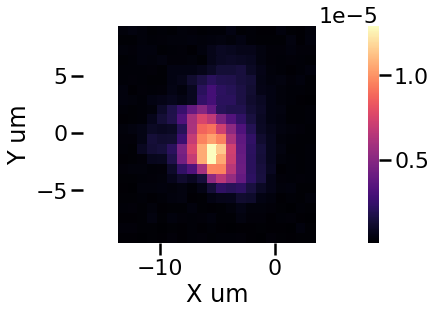

In [16]:
ax = myheatmap(amp1.iloc[6:-2,5:-5])
ax.axis('equal')

17844221.10552779
PosGU01Arrray01.00r0.5p3Device0.1Drum2_10V114238


<ipython-input-1-3b29350f94bc>:53: RuntimeWarning: divide by zero encountered in double_scalars
  normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
<ipython-input-1-3b29350f94bc>:57: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  return sp.ma.masked_array(sp.interp(value, x, y))
<ipython-input-1-3b29350f94bc>:53: RuntimeWarning: divide by zero encountered in double_scalars
  normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
<ipython-input-1-3b29350f94bc>:57: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  return sp.ma.masked_array(sp.interp(value, x, y))


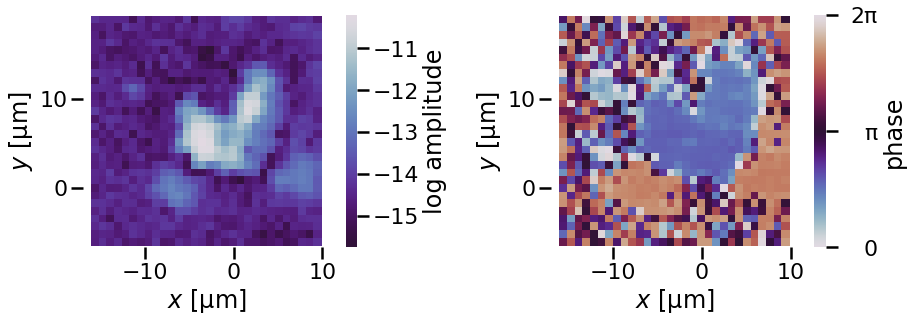

In [17]:
# need to fix
file = 'PosGU01Arrray01.00r0.5p3Device0.1Drum2_10V114238' 
path = os.path.join(folder2,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']
print(df.frequency[0])
# calculate corre"cted phase
df['phase_cor'] = df.phase + radians_correction(df.frequency[0]) ## correction for radians
df['phase_cor_wrap'] = df.phase_cor % (2 * np.pi)

fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(13.23,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1)
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log(amp1)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')


plt.sca(ax2) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase_cor_wrap').sort_index(axis = 0, ascending = False) 
_,cbar = myheatmap(phase1, 'phase',vmin=0, vmax = 2*np.pi, cmap=divergingcmap, return_cbar=True);
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
cbar.set_ticks([0, np.pi, 2*np.pi])
cbar.ax.set_yticklabels(['0', '\u03C0', '2\u03C0'],ha='right')  # make sure this line is joined with the one above it.
"""cbar.set_ticks([-np.pi, 0, np.pi])
cbar.ax.set_yticklabels(['$-$\u03C0', '0', '$+$\u03C0'],ha='right')  # make sure this line is joined with the one above it."""
cbar.ax.yaxis.set_tick_params(pad=40)  # your number may vary

print(file)
plt.tight_layout();

<ipython-input-1-3b29350f94bc>:53: RuntimeWarning: divide by zero encountered in double_scalars
  normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
<ipython-input-1-3b29350f94bc>:57: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  return sp.ma.masked_array(sp.interp(value, x, y))


PosGU01Arrray01.00r0.5p3Device0.1Drum2_10V114238


<ipython-input-1-3b29350f94bc>:53: RuntimeWarning: divide by zero encountered in double_scalars
  normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
<ipython-input-1-3b29350f94bc>:57: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  return sp.ma.masked_array(sp.interp(value, x, y))


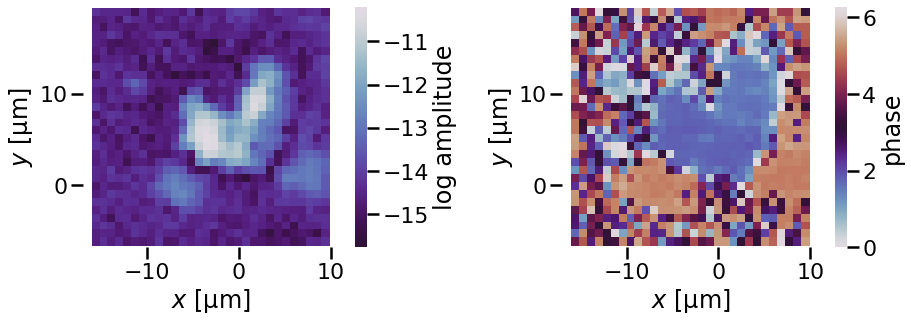

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(13.23,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1)
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log(amp1)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')


plt.sca(ax2) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase_cor_wrap').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase',vmin=0, vmax = 2*np.pi, cmap=divergingcmap);
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')

print(file)
plt.tight_layout();

'plt.figure()\nmyheatmap(np.nanmax(np.array(-np.log(-x1)),np.array(np.log(x1)))'

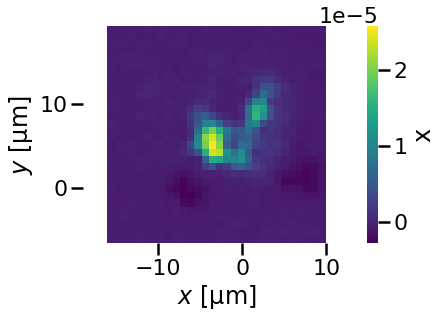

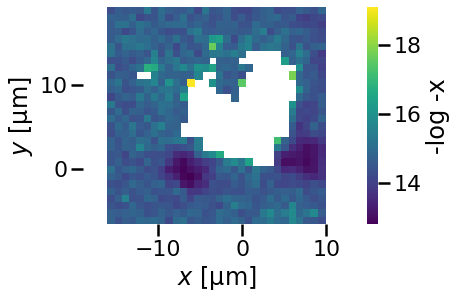

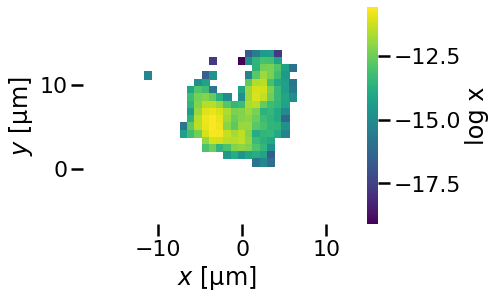

In [19]:
x1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'x').sort_index(axis = 0, ascending = False) 

myheatmap(x1, 'x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

plt.figure()
myheatmap(-np.log(-x1), '-log -x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

plt.figure()
myheatmap(np.log(x1), 'log x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

"""plt.figure()
myheatmap(np.nanmax(np.array(-np.log(-x1)),np.array(np.log(x1)))"""

In [20]:
#np.nanmax(np.array(-np.log(-x1)),np.array(np.log(x1)))

<ipython-input-1-3b29350f94bc>:57: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  return sp.ma.masked_array(sp.interp(value, x, y))


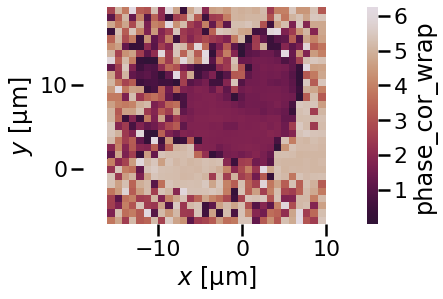

In [21]:
  
# set midpoint at zero.
vmin = np.array(phase1).min()
vmax = np.array(phase1).max()
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)


## Plot with a norm at 0
myheatmap(phase1, 'phase_cor_wrap', norm = norm,
          cmap=divergingcmap);
plt.gca().axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]');

In [22]:
if plot3d:
    from mpl_toolkits import mplot3d
    ax = plt.axes(projection='3d')
    X, Y = np.meshgrid(phase1.columns,phase1.index )
    ax.plot_surface(X,Y,phase1, 
                    norm=norm,  # set midpoint at 0.
                    antialiased=False,
                    cmap=divergingcmap )
    plt.xlabel(phase1.columns.name)
    plt.ylabel(phase1.index.name)
    ax.set_title(file);
    ax.view_init(elev=60., azim=0)

<ipython-input-1-3b29350f94bc>:53: RuntimeWarning: divide by zero encountered in double_scalars
  normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
<ipython-input-1-3b29350f94bc>:57: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  return sp.ma.masked_array(sp.interp(value, x, y))


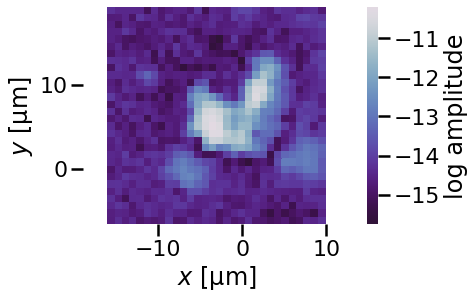

In [29]:
## Cut colorbar in half.

data = np.log(amp1)

# set white at max.
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)


## Plot with a midpoint at 0.
myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.gca().axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]');

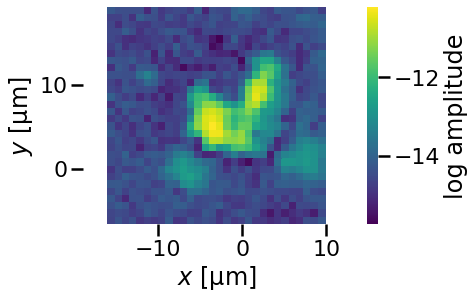

In [24]:
myheatmap(np.log(amp1), 'log amplitude', cmap = 'viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if plot3d:
    plt.figure()
    ax = plt.axes(projection='3d')
    X, Y = np.meshgrid(amp1.columns,amp1.index )
    ax.plot_surface(X,Y,(amp1), 
                    antialiased=False,
                    cmap='viridis', )
    plt.xlabel(amp1.columns.name)
    plt.ylabel(amp1.index.name)
    ax.set_title(file);
    ax.view_init(elev=60., azim=0)

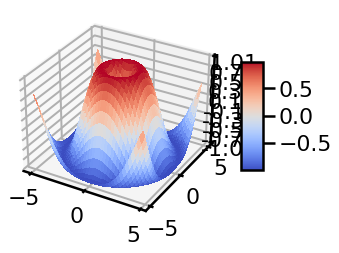

In [25]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

<ipython-input-1-3b29350f94bc>:53: RuntimeWarning: divide by zero encountered in double_scalars
  normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
<ipython-input-1-3b29350f94bc>:57: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  return sp.ma.masked_array(sp.interp(value, x, y))
<ipython-input-1-3b29350f94bc>:53: RuntimeWarning: divide by zero encountered in double_scalars
  normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
<ipython-input-1-3b29350f94bc>:57: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  return sp.ma.masked_array(sp.interp(value, x, y))


Figure not overwritten:
\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Papers and Abstracts\Coupled Resonator Spatial Imaging\Figures\python_exports\ResCurvesAndModeMaps.pdf


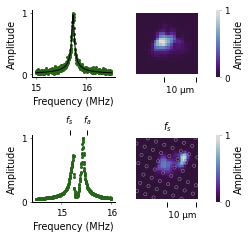

In [26]:
#### Want to plot together: single resonance peak, mode map, double resonance peak, mode map
import lmfit as lf
from lmfit.models import DampedOscillatorModel

widths = [1,1]
heights = [1, 1]
gs_kw = dict(width_ratios=widths, height_ratios=heights)

sns.set_context('paper')
# subplotssty={'figsize':(3.37,3.3), "constrained_layout":True, 'gridspec_kw':gs_kw} # use 3.3 if no plot title
subplotssty={'figsize':(3.37,3.2), "constrained_layout":True, 'gridspec_kw':gs_kw}

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, **subplotssty)

"""Plot single resonator curve"""

## Mac vs Windows
#base = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/ResonanceCurves/'
#savefolder = '/Volumes/Aleman-Lab/Group/Papers and Abstracts/Coupled Resonator Spatial Imaging/Figures/python_exports/'
base = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\ResonanceCurves'
savefolder = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Papers and Abstracts\Coupled Resonator Spatial Imaging\Figures\python_exports'
path = os.path.join(base, 'Array01.00r0.5p3Device0.0Drum1_2','Data.csv')
colnames = ['SweepVal', 'F', 'R', 'theta', 'NEP_BW', 'R_ref', 'theta_ref', 'Amp', 'Phase']
df = pd.read_csv(path, names = colnames)

#Find resonant frequency and normalize F and R^2 values
maxR = df['R'].max()
maxFreqIn = (df['R'].idxmax())
max1 = maxR

df['Rnorm'] = (df.R) / (maxR)
df['Fnorm'] = df.F / 10**6
res = df['Fnorm'].values[maxFreqIn]
# Define model
model = DampedOscillatorModel()
model.param_names
# Fit
guessQ = 1000
params = model.make_params(sigma = 1/(2*guessQ), center = res, amplitude = 1 / (guessQ*res))
result = model.fit(df.Rnorm, params, x = df.Fnorm)
# Plot
sty = {'markersize':4, "lw":1}
ax1.plot(df.Fnorm, df.Rnorm, '.', color='#276419' , **sty )
ax1.plot(df.Fnorm, result.best_fit, '-k', **sty)
ax1.set_xlabel('Frequency (MHz)')
ax1.set_ylabel('Amplitude')

""" Plot the mode map for the single resonator """
plt.sca(ax2)
data = singleresdata.iloc[6:-2,4:-4]
if rotating:
    data=rotatehack(data)
#vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=0, vmax=vmax, midpoint=vmax)
_, cbar = myheatmap(data, 'Amplitude', norm = greennorm,
                      cmap=cmapforhalf, return_cbar=True);
#cbar.ax.set_ylim(-1,1)
cbar.set_ticks([1,0])
cbar.ax.tick_params(length=cbarticklength, width=tickwidth)
ax2.axis('equal')

# Create scale-bar
topx = data.columns.max()
plt.xticks([topx-10, topx])
plt.gca().set_xticklabels([u'            10 μm', ''])
plt.yticks([]) # remove y ticks, since we can use the xticks alone on a square plot

#plt.xlabel(u'$x$ [μm]')
#plt.ylabel(u'$y$ [μm]')
plt.xlabel('')
plt.ylabel('')

""" Double resonant curve """

plt.sca(ax3)
#base = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/ResonanceCurves/'
base = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\ResonanceCurves'
path = os.path.join(base, 'Array01.00r0.5p3Device1.2Drum1Couping500/Data.csv')
colnames = ['SweepVal', 'F', 'R', 'theta', 'NEP_BW', 'R_ref', 'theta_ref', 'Amp', 'Phase']
df = pd.read_csv(path, names = colnames)
maxR = df['R'].max()
df['Rnorm'] = (df.R) / (maxR)
max3 = maxR
df['Fnorm'] = df.F / 10**6
sty = {'markersize':4}
ax3.plot(df.Fnorm, (df.Rnorm), '.', color=('#276419'),**sty)
ax3.set_xlabel('Frequency (MHz)')
ax3.set_ylabel('Amplitude')
## add marks where the frequencies are
axtop = ax3.twiny()
xlims = ax3.get_xlim()
axtop.set_xlim(xlims)
axtop.tick_params(bottom=False, top=True, left=False, right=False)
axtop.set_xticks([low_mode_Hz / 1e6, high_mode_Hz / 1e6])
#axtop.set_xticklabels([])
axtop.set_xticklabels(['$f_s$', '$f_a$'])


""" Mode map corresponding to double resonant curve """

plt.sca(ax4)
max4 = doubleresonatordata.max().max()
data = doubleresonatordata/doubleresonatordata.max().max()
if rotating:
    data = rotatehack(data)
#vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=0, vmax=vmax, midpoint=vmax)

_,cbar = myheatmap(data, 'Amplitude', norm = greennorm,
          cmap=cmapforhalf, return_cbar= True);
ax4.axis('equal')
cbar.set_ticks([1,0])
cbar.ax.tick_params(length=cbarticklength, width=tickwidth)


if add_circle:
    if rotating:
        coordinateslist = coordlistrot
    else:
        coordinateslist = coordlist
    for coords in coordinateslist:  
        thiscircle = plt.Circle(coords, radius=radius, color='w', fill = None, alpha = .5, lw = .5)
        plt.gca().add_artist(thiscircle)
        
plt.title('$f_s$')

# Create scale-bar
topx = data.columns.max()
plt.xticks([topx-10, topx])
plt.gca().set_xticklabels([u'           10 μm', ''])
plt.yticks([]) # remove y ticks, since we can use the xticks alone on a square plot

#plt.xlabel(u'$x$ [μm]')
#plt.ylabel(u'$y$ [μm]')
plt.xlabel('')
plt.ylabel('')

for ax in [ ax3, ax1]:
    ax.tick_params(direction='out', length=ticklength, width=tickwidth)
    ax.set_yticks([0,1])
"""    ax.spines['left'].set_linewidth(.5)
    ax.spines['right'].set_linewidth(.5)
    ax.spines['top'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)"""
    
sns.despine()
    
savename = 'ResCurvesAndModeMaps.pdf'
if saving:
    plt.savefig(os.path.join(savefolder,savename), bbox_inches='tight',pad_inches=0)
    print('Figure saved:')
else:
    print("Figure not overwritten:")
print(os.path.join(savefolder, savename))

sns.set_context('poster') # make font large again.

In [27]:
print(max1)
print(max2)
print(max3)
print(max4)

1.369976370913e-05
1.2934e-05
3.562592373368e-05
4.1342e-05
